# Tema 4

## Ejemplo de solución automática al problema de clase




Usamos para esta solución el mismo código que vemos en la actividad 1

In [1]:
!pip install simpleai flask pydot graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleai: filename=simpleai-0.8.3-py3-none-any.whl size=100982 sha256=38d321625924d73fdbd5f802a13ec13e514a747900c1c856ab0240a4517c6d1b
  Stored in directory: /root/.cache/pip/wheels/ec/02/a7/f0077617a5f73eb1c52e45f12a9da3f0bafff3902bcd91766f
Successfully built simpleai


Vamos a codificar un problema de búsqueda directamente con el grafo del problema. Para ello creamos un objeto json que podríamos salvar o recuperar de un fichero aparte.

```
{
  "origen1": { "destino1": coste1 , "destino2": coste2 , ... },
  "origen2": ...,
  ...
}
```

In [2]:
#!/usr/bin/env python
# coding: utf-8

# 2024 Modified by: Alejandro Cervantes
# Remember installing pyplot and flask if you want to use WebViewer

# NOTA: WebViewer sólo funcionará si ejecutáis en modo local

from __future__ import print_function

import math, json
from simpleai.search.viewers import BaseViewer,ConsoleViewer,WebViewer
from simpleai.search import SearchProblem, astar, breadth_first, depth_first, uniform_cost

'''
Esta clase espera un grafo expresado en JSON de la siguiente forma

{
  "origen1": { "destino1": coste1 , "destino2": coste2 , ... },
  "origen2": ...,
  ...
}

Esto lo guardamos como datos del problema para luego extraer de ahí toda la información

'''
class StaticGraphSearch(SearchProblem):

    def __init__(self, graph, initial, goals, reverse_order=False):
        self.graph = json.loads(graph) # Transforms to python object
        self.goals = goals
        self.initial = initial
        self.reverse_order = reverse_order
        self.node_graph = self.get_node_graph()
        super(StaticGraphSearch, self).__init__(initial_state=self.initial) # Required by simple-ai

    # Funciones de utilidad para manejo del grafo del problema
    def graph_successors(self,node):
        list_of_successors = list(k for k in self.graph[node].keys())
        if self.reverse_order:
          list_of_successors.reverse()

        return list_of_successors

    def get_node_graph(self):
        return { k:self.graph_successors(k) for k in self.graph.keys() }

    '''
       FUNCIONES NECESARIAS PARA LA BÚSQUEDA

       1. Como acción guardaremos siempre la tupla (origen, destino), así se puede mostrar luego el camino
       2. Como resultado de una acción será el destino (accederemos al segundo campo)
       3. Como comprobación de final miraremos si el estado está en la lista de destinos que se pasa como parámetro
       4. El coste de una transición está también en el grafo

    '''
    def actions(self, state):
        actions = []
        for destiny in list(self.node_graph[state]):
          actions.append((state,destiny))
        return actions

    def result(self, state, action):
      if state == action[0]:
        return action[1]
      else:
        raise Exception("result: Invalid pair state, action: state: {} action: {}".format(state,action))

    def is_goal(self, state):
        return state in self.goals

    def cost(self, state, action, state2):
      if state == action[0] and state2 == action[1]:
        return self.graph[state][action[1]]
      else:
        raise Exception("cost: Invalid state, action, state2: state: {} action: {} state2: {}".format(state,action,state2))

    # Tema 5
    def heuristic(self,state):
      return 0



In [3]:
def searchInfo (problem,result,use_viewer):
    def getTotalCost (problem,result):
        originState = problem.initial_state
        totalCost = 0
        for action,endingState in result.path():
            if action is not None:
                totalCost += problem.cost(originState,action,endingState)
                originState = endingState
        return totalCost


    res = "Total length of solution in nodes: {0}\n".format(len(result.path()))
    res += "Total length of solution in actions: {0}\n".format(len(result.path())-1)
    res += "Total cost of solution: {0}\n".format(getTotalCost(problem,result))

    if use_viewer:
        stats = [{'name': stat.replace('_', ' '), 'value': value}
                         for stat, value in list(use_viewer.stats.items())]

        for s in stats:
            res+= '{0}: {1}\n'.format(s['name'],s['value'])
    return res

def resultado_experimento(problem,result,used_viewer):
    path = [x[1] for x in result.path()] # x[0] contiene la acción, x[1] contiene el destino
    print ('La solución encontrada es: ', path)
    print ('Información sobre la búsqueda: ')
    info=searchInfo(problem,result,used_viewer)
    print(info)

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(self,file=None,title='Grafo del problema',xoffset=0.075,yoffset=0.075):
        # Define the graph based on your problem_and_costs_graph
        graph_data = self.graph
        node_h = None

        # Create a NetworkX graph
        graph = nx.DiGraph()

        # Add edges and their weights to the graph
        for start_node, edges in graph_data.items():
            for end_node, weight in edges.items():
                graph.add_edge(start_node, end_node, weight=weight)

        # Visualize the graph
        pos = nx.planar_layout(graph)  # You can use other layouts like shell_layout, etc.
        # pos = nx.shell_layout(graph)
        # pos = nx.kamada_kawai_layout(graph)

        nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12, font_weight='bold', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        nx.draw_networkx_nodes(graph, pos, nodelist=[self.initial], node_color='red', node_size=1000)
        nx.draw_networkx_nodes(graph, pos, nodelist=self.goals, node_color='lightgreen', node_size=1000)

        if node_h is not None:
            label_pos = { p[0] : np.array([p[1][0]+xoffset,p[1][1]+yoffset]) for p in pos.items() }
            label_text = { p[0] : f'h={node_h[p[0]]}' for p in pos.items() }
            nx.draw_networkx_labels(graph, pos=label_pos, labels=label_text, font_size=12, font_weight='bold')

        plt.title(title)

        if file is None:
            plt.show()
        else:
            plt.savefig(file)
            plt.close()
        return pos

# Ejemplos para la clase

Primer ejemplo, básico con 4 nodos

In [21]:
problem_and_costs_graph='''{
  "a": { "b": 1 , "c": 1 , "d": 4 },
  "b": { "d": 1 },
  "c": { "d": 1 },
  "d": { }
}'''

initial='a'
goals=('d')

Código para realizar búsqueda en amplitud

In [26]:
problem = StaticGraphSearch(problem_and_costs_graph,initial,goals)
used_viewer=BaseViewer()


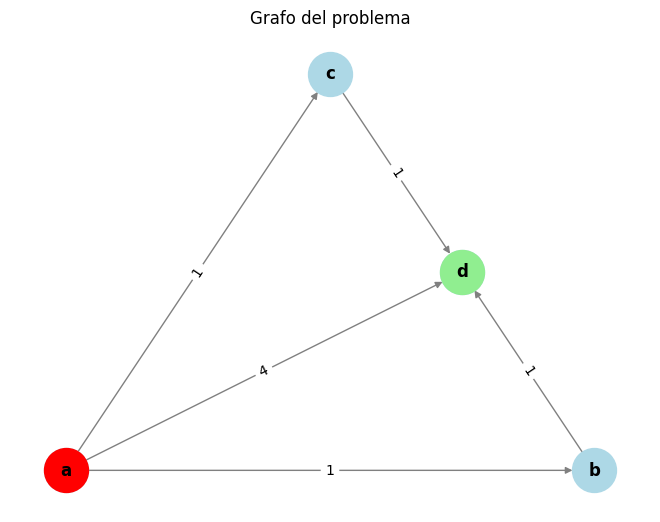

In [27]:
_ = plot_graph(problem)

In [28]:
# Probad también ConsoleViewer para depurar
# No podréis usar WebViewer en Collab para ver los árboles

result = breadth_first(problem, graph_search=True,viewer=used_viewer)
resultado_experimento(problem,result,used_viewer)

La solución encontrada es:  ['a', 'd']
Información sobre la búsqueda: 
Total length of solution in nodes: 2
Total length of solution in actions: 1
Total cost of solution: 4
max fringe size: 3
visited nodes: 4
iterations: 4



In [29]:
used_viewer=ConsoleViewer()
result = breadth_first(problem, graph_search=True,viewer=used_viewer)
resultado_experimento(problem,result,used_viewer)

After each step, a prompt will be shown.
On the prompt, you can just press Enter to continue to the next step.
But you can also have this commands:
(write the command you want to use and then press Enter)
* h: get help.
* g PATH_TO_PNG_IMAGE: create png with graph of the current state.
* e: run non-interactively to the end of the algorithm.
* s: show statistics of the execution (max fringe size, visited nodes).
* q: quit program.
EVENT: started
Algorithm just started.
> 
EVENT: new_iteration
New iteration with 1 elements in the fringe:
[Node <a>]
> 
EVENT: chosen_node
Chosen node: Node <a>
Not goal
> 
EVENT: expanded
Expanded [Node <a>]
Successors: [[Node <b>, Node <c>, Node <d>]]
> 
EVENT: new_iteration
New iteration with 3 elements in the fringe:
[Node <b>, Node <c>, Node <d>]
> 
EVENT: chosen_node
Chosen node: Node <b>
Not goal
> 
EVENT: expanded
Expanded [Node <b>]
Successors: [[Node <d>]]
> 
EVENT: new_iteration
New iteration with 2 elements in the fringe:
[Node <c>, Node <d>]
> 


Problema de ejemplo para la sesión

In [14]:
problem_and_costs_graph='''{
  "s": { "b": 1 , "c": 4 },
  "a": { "c": 1 },
  "b": { "a": 1 , "e" : 7 },
  "c": { "b": 2 , "d": 5, "g1": 21 },
  "d": { "f": 6, "g2": 11 },
  "e": { "d": 3, "f": 10 },
  "f": { },
  "g1": { },
  "g2": { }
  }'''

initial='s'
goals=('g1','g2')


In [15]:
problem = StaticGraphSearch(problem_and_costs_graph,initial,goals)
# plot_graph(problem.graph,title='Grafo del problema de clase')

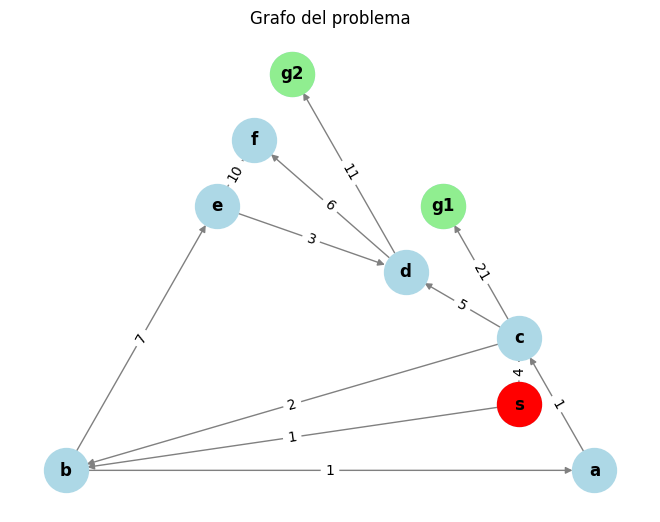

In [16]:
_= plot_graph(problem)

In [18]:
problem = StaticGraphSearch(problem_and_costs_graph,initial,goals)
used_viewer=BaseViewer()
result = breadth_first(problem, graph_search=True,viewer=used_viewer)
resultado_experimento(problem,result,used_viewer)

La solución encontrada es:  ['s', 'c', 'g1']
Información sobre la búsqueda: 
Total length of solution in nodes: 3
Total length of solution in actions: 2
Total cost of solution: 25
max fringe size: 4
visited nodes: 7
iterations: 7



In [19]:
problem = StaticGraphSearch(problem_and_costs_graph,initial,goals)
used_viewer=BaseViewer()
result = depth_first(problem, graph_search=True,viewer=used_viewer)
resultado_experimento(problem,result,used_viewer)

La solución encontrada es:  ['s', 'c', 'g1']
Información sobre la búsqueda: 
Total length of solution in nodes: 3
Total length of solution in actions: 2
Total cost of solution: 25
max fringe size: 3
visited nodes: 3
iterations: 3



In [20]:
problem = StaticGraphSearch(problem_and_costs_graph,initial,goals,reverse_order=True)
used_viewer=BaseViewer()
result = depth_first(problem, graph_search=True,viewer=used_viewer)
resultado_experimento(problem,result,used_viewer)

La solución encontrada es:  ['s', 'b', 'e', 'd', 'g2']
Información sobre la búsqueda: 
Total length of solution in nodes: 5
Total length of solution in actions: 4
Total cost of solution: 22
max fringe size: 3
visited nodes: 6
iterations: 6

